In [1]:
import uproot
import re
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import torch_geometric.transforms as T

from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm

from iminuit import Minuit, describe
from probfit import Extended, BinnedChi2
from probfit import gaussian, linear, poly2, Chi2Regression
from scipy   import integrate

/lhome/ific/f/fkellere/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def gaussNorm(x, mu, sigma, N):
    return (N*np.exp(-0.5 * np.power((x - mu)/(sigma),2 ))/( sigma * np.sqrt( 2 * np.pi)))

def expNorm(x, C, s, xmin, xmax):
    return C * s * np.exp(-x * s) /  (np.exp(-s * xmin) - np.exp(-s * xmax))

def gaussExp_Norm(x, mu, sigma, N, C, s, xmin, xmax) :
    return gaussNorm(x, mu, sigma, N) + expNorm(x, C, s, xmin, xmax)

In [3]:
fold   = '/lhome/ific/f/fkellere/NEXT_Graphs/weaver-benchmark/weaver/output_PN_RecoBig_Transform/'

In [4]:
def PN_analysis(folder, file):
    tree   = uproot.open(folder+file)['Events']
    df     = tree.arrays(tree.keys(),library='pd')
    y_pred = df['score_is_signal'].values
    E      = df['E_tot'].values
    
    return E, y_pred

In [5]:
E, y_predict = PN_analysis(fold,'particlenet_predict_data.root')

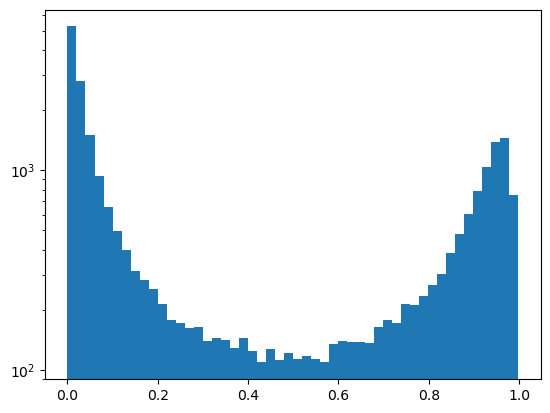

In [6]:
plt.hist(y_predict,50);
plt.semilogy();

In [7]:
cut = np.median(y_predict)

In [8]:
S           = []
B           = []
for i in tqdm(range(0,len(E))):
    if y_predict[i]<cut:
        B.append(E[i])
    else:
        S.append(E[i])

  0%|          | 0/24831 [00:00<?, ?it/s]

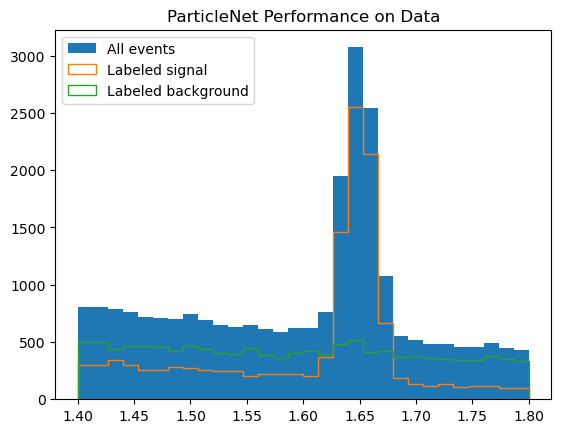

In [9]:
plt.hist(E,30,label='All events')
plt.hist(S,30,histtype='step',label='Labeled signal')
plt.hist(B,30,histtype='step',label='Labeled background')
plt.title('ParticleNet Performance on Data')
plt.legend();

  0%|          | 0/24831 [00:00<?, ?it/s]

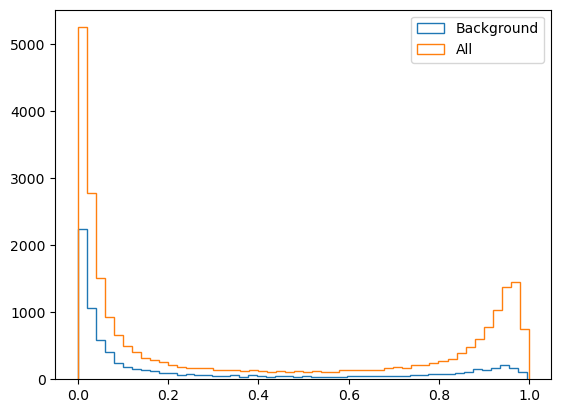

In [10]:
#Background scores (below 1.55 MeV) vs. overall scores
y_pred_B = []
for i in tqdm(range(0,len(y_predict))):
    if E[i]<1.55:
        y_pred_B.append(y_predict[i])
plt.hist(y_pred_B,50,histtype='step',label='Background');
plt.hist(y_predict,50,histtype='step',label='All');
plt.legend()
#plt.semilogy()

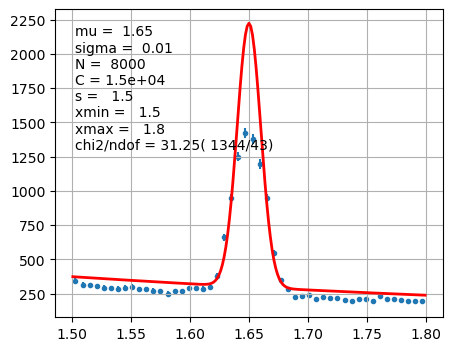

In [11]:
# Create the cost function.
bins_fit   = 50
fit_range  = (1.5, 1.8)
mu         = 1.65
sigma      = 0.01
N          = 8000
C          = 15000
s          = 1.5

E = np.array(E, dtype=np.double)

plt.figure(figsize=(5,4))
chi2 = BinnedChi2(gaussExp_Norm, E, bins=bins_fit , bound=fit_range)
chi2.show(args={'mu':mu, 'sigma':sigma, 'N':N,  'C':C, 's':s , 'xmin':fit_range[0], 'xmax':fit_range[1]})
plt.show()

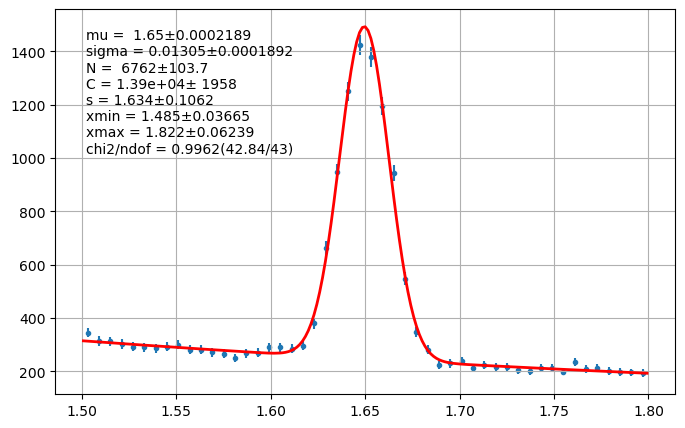

Mean:  1.65         +/- 0.00022 
Sigma: 0.01        +/- 0.00019 
N:     6762.2            +/- 104 
C:     13901.4            +/- 1958 
s:     1.6            +/- 0.11 
chi2:  1.00     


In [12]:
# Perform the fit.
plt.figure(figsize=(8,5))
minuit = Minuit(chi2, mu=mu, sigma=sigma, N=N,  C=C, s=s, xmin=fit_range[0], xmax=fit_range[1])
minuit.migrad()
chi2.show(minuit)
plt.show()

mean      = minuit.values[0]
mean_u    = minuit.errors[0]

sigma     = minuit.values[1]
sigma_u   = minuit.errors[1]

N         = minuit.values[2]
N_u       = minuit.errors[2]

C         = minuit.values[3]
C_u       = minuit.errors[3]

s         = minuit.values[4]
s_u       = minuit.errors[4]

chi2_result = minuit.fval/chi2.ndof

print(f'Mean:  {mean:.2f}         +/- {mean_u:.5f} ')
print(f'Sigma: {sigma:.2f}        +/- {sigma_u:.5f} ')
print(f'N:     {N:.1f}            +/- {N_u:.0f} ')
print(f'C:     {C:.1f}            +/- {C_u:.0f} ')
print(f's:     {s:.1f}            +/- {s_u:.2f} ')
print(f'chi2:  {chi2_result:.2f}     ')

In [13]:
Nt = integrate.quad(lambda x: gaussExp_Norm(x,minuit.values[0],minuit.values[1],minuit.values[2],minuit.values[3],
                                       minuit.values[4],fit_range[0],fit_range[1]),
                    minuit.values[0]-3*minuit.values[1],minuit.values[0]+3*minuit.values[1])
NS = minuit.values[2]
NB = Nt[0]-minuit.values[2]

In [14]:
ROCx = []
ROCy = []
FOM  = []
for c in np.linspace(0,1,10):
    S    = [E[i] for i in range(len(y_predict)) if y_predict[i]>c]
    try:
        chi2 = BinnedChi2(gaussExp_Norm, S, bins = bins_fit , bound=fit_range)
    except ValueError:
        ROCx.append(1)
        ROCy.append(0)
        FOM. append(0)
        continue
    minuit = Minuit(chi2, mu=mu, sigma=sigma, N=N*len(S)/len(E),  C=C*len(S)/len(E),
                    s=s, xmin=fit_range[0], xmax=fit_range[1])
    minuit.migrad()
    chi2_result = minuit.fval/chi2.ndof
    print(f'chi2: {chi2_result}')
    Nt = integrate.quad(lambda x: gaussExp_Norm(x,minuit.values[0],minuit.values[1],minuit.values[2],
                                               minuit.values[3],minuit.values[4],fit_range[0],fit_range[1]),
                       minuit.values[0]-3*minuit.values[1],minuit.values[0]+3*minuit.values[1])
    minuit.values[2]
    ROCx.append(1-(Nt[0]-minuit.values[2])/NB)
    ROCy.append(minuit.values[2]/NS)
    FOM. append(minuit.values[2]*np.sqrt(NB)/(NS*np.sqrt(Nt[0]-minuit.values[2])))

chi2: 0.9961983795641256
chi2: 1.215094631458905
chi2: 1.1785874112483294
chi2: 1.189980887654379
chi2: 1.2347234888097856
chi2: 1.2776992025590845
chi2: 1.3839842680343224
chi2: 1.3799162271376149
chi2: 1.487533790126563


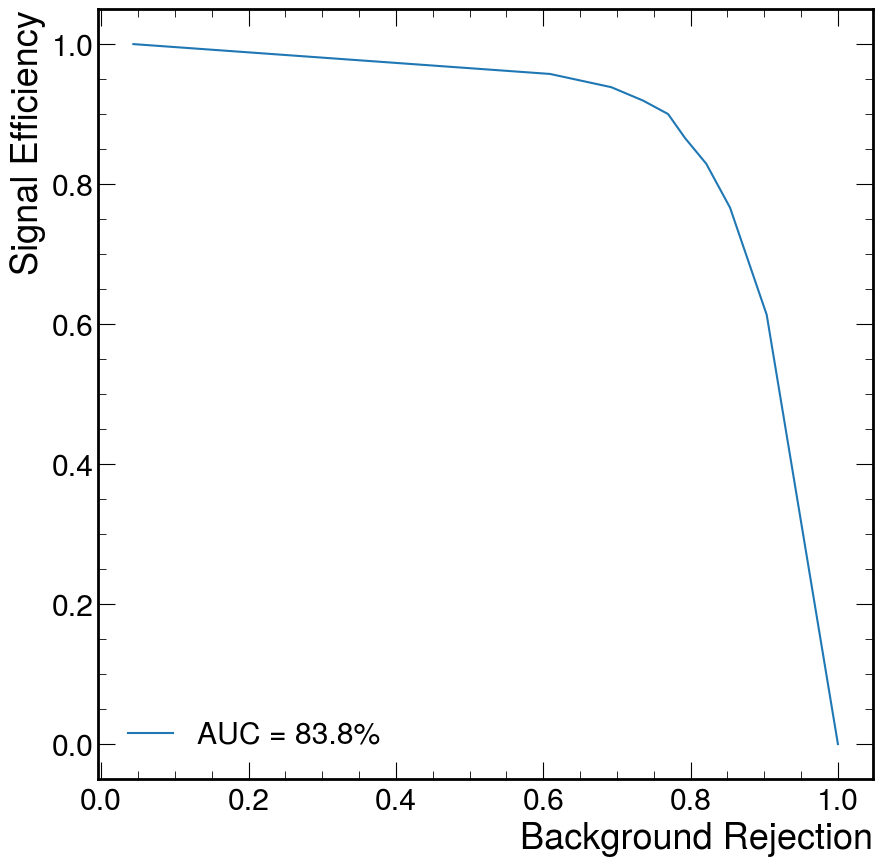

In [15]:
plt.style.use(hep.style.ROOT)
plt.plot(ROCx,ROCy,label="AUC = {:.1f}%".format(integrate.trapezoid(ROCy,ROCx)*100))
plt.xlabel(r'Background Rejection')
plt.ylabel(r'Signal Efficiency')
plt.legend()

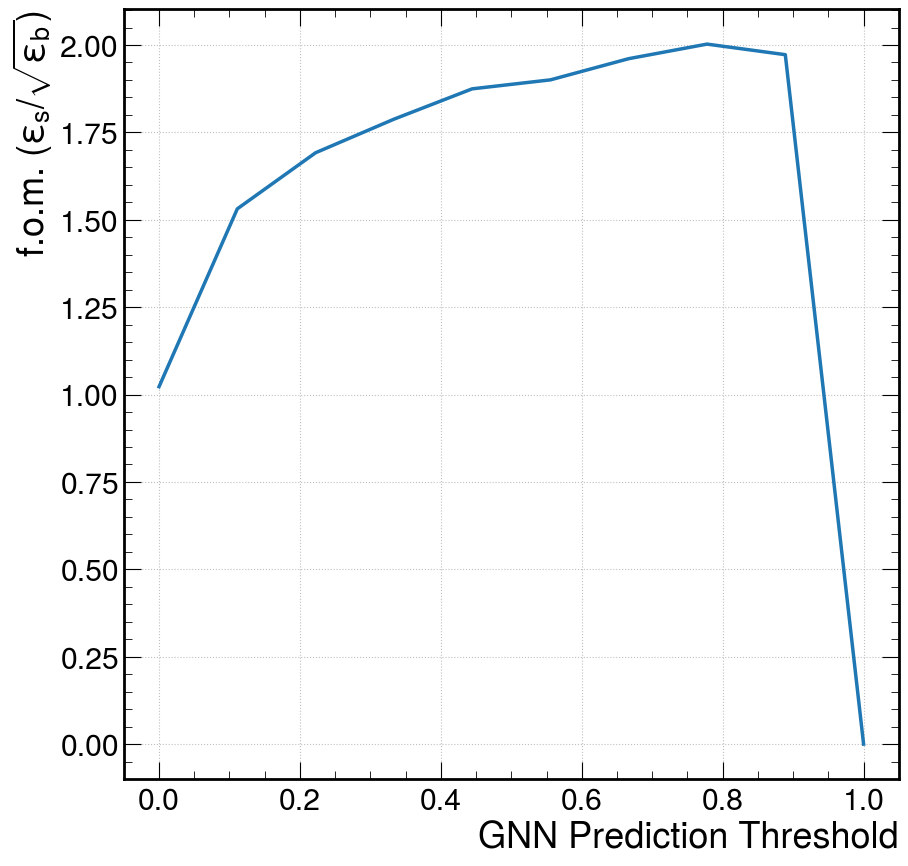

In [16]:
plt.figure()
plt.plot(np.linspace(0,1,10), FOM, lw=2.5)
plt.xlabel(r'GNN Prediction Threshold')
plt.ylabel(r'f.o.m. ($\epsilon_{s}/\sqrt{\epsilon_{b}}$)')
plt.grid(True)
plt.show()

In [17]:
fom  = [x for x in FOM if x!=np.inf]
xmax = np.linspace(0,1,10)[np.argmax(fom)]
print(f'Max FOM: {max(fom).round(2)} at threshold {xmax.round(2)}')

Max FOM: 2.0 at threshold 0.78


In [22]:
thre_PN = np.linspace(0,1,10)
Figm_PN = FOM
Seff_PN = ROCy
Brej_PN = ROCx
%store thre_PN
%store Figm_PN
%store Seff_PN
%store Brej_PN

Stored 'thre_PN' (ndarray)
Stored 'Figm_PN' (list)
Stored 'Seff_PN' (list)
Stored 'Brej_PN' (list)
